<a href="https://colab.research.google.com/github/robinyUArizona/PyTorch-Deep-Learning/blob/main/convolutional_NeuralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Ref: https://www.youtube.com/watch?v=33ysE1Gt1G4&list=PLCC34OHNcOtpcgR9LEYSdi9r7XIbpkpK1&index=14

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Convert MNIST Image Files into a Tensor of 4-Dimensions (# of images, Height, Width, Color Channel)
transform = transforms.ToTensor()

In [3]:
# Train Data
train_data =  datasets.MNIST(root="/cnn_data", train=True, download=True, transform=transform)

In [4]:
# Test Data
test_data =  datasets.MNIST(root="/cnn_data", train=False, download=True, transform=transform)

In [5]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [7]:
# Create a small batch size for images ... Let's say 10
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader =  DataLoader(test_data, batch_size=10, shuffle=False)

In [8]:
# Define our CNN Model
# Describe convolutional layer and what it's doing (2 convolutional layers)
# This is just an example
# 1 is # of input image
# 6 is # of output feature maps
# 3 is 3X3 kernel filter
# 1 is stride .. step
conv1 = nn.Conv2d(1, 6, 3, 1)
conv2 = nn.Conv2d(6, 16, 3, 1)

In [9]:
# Grab 1 MNIST record/image
for i, (X_train, y_train) in enumerate(train_data):
    break


In [10]:
X_train.shape

torch.Size([1, 28, 28])

In [11]:
x = X_train.view(1, 1, 28, 28)
# x
# 1 batch of 1 image of size 28 X 28

In [12]:
# Perform our first convolution
x = F.relu(conv1(x)) # Recitified Linear Unit for our activation function

In [13]:
x.shape
# 1 single image
# 6 filters gives 6 feature maps
# 26 X 26 is the size of the image

torch.Size([1, 6, 26, 26])

In [14]:
# Pass through the pooling layer
# kernel size of 2 and stride size of 2
x = F.max_pool2d(x, 2, 2)

In [15]:
x.shape # 26/2 = 13

torch.Size([1, 6, 13, 13])

In [16]:
# Second convolutional layer
x = F.relu(conv2(x))

In [17]:
x.shape # we did not set padding so we lose 2 pixels around outside

torch.Size([1, 16, 11, 11])

In [18]:
# Pooling layer
x = F.max_pool2d(x, 2, 2)

In [19]:
x.shape # 11/2 = 5.5

torch.Size([1, 16, 5, 5])

In [20]:
((28-2) / 2 - 2) / 2

5.5

In [21]:
# Model Class
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1, padding=0) #
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1, padding=0) #
        # Fully Connected Layer
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2) # 2X2 kernal and stride 2
        # Second pass
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2) # 2X2 kernal and stride 2

        # Re-view to flatten it out
        X = X.view(-1, 16*5*5) # negative one so that we can vary the batch size

        # Fully Connected Layers
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [22]:
# Create an Instance of our Model
torch.manual_seed(41)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [23]:
# Loss Function Optimize
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [24]:
import time
start_time = time.time()

# Create Variables To Tracks Things
epochs = 5
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# For Loop of Epochs
for epoch in range(epochs):
    trn_corr = 0
    tst_corr = 0

    # Train
    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1
        y_pred = model.forward(X_train) # get predicted values from the training set
        train_loss = criterion(y_pred, y_train)

        # Calculate accuracy
        _, predicted = torch.max(y_pred, 1)
        batch_correct = (predicted == y_train).sum().item()
        train_accuracy = 100 * batch_correct / y_train.size(0)
        # trn_corr += train_accuracy

        # Update our parameters
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        # Print out some results
        if b%600 == 0:
            print(f"Epoch: {i} Batch: {b} Loss: {train_loss.item()}")

    train_losses.append(train_loss.detach().numpy())
    train_accuracies.append(train_accuracy)

    # Test
    with torch.no_grad(): # No gradient so we dont updated our weights and biases with test
        for b, (X_test, y_test) in enumerate(test_loader):
            b += 1
            y_val_pred = model.forward(X_test) # get predicted values from the training set
            val_loss = criterion(y_val_pred, y_test)

            # Calculate validation accuracy
            _, val_predicted = torch.max(y_val_pred, 1)
            batch_correct = (val_predicted == y_test).sum().item()
            val_accuracy = 100 * batch_correct / y_test.size(0)
            # tst_corr += val_accuracy


    val_losses.append(val_loss.detach().numpy())
    val_accuracies.append(val_accuracy)

#  # print
#     if epoch%10 == 0:
#         print(f"Epoch: {epoch}, "
#                 f"Training Loss: {train_loss.item():.4f}, Training Accuracy: {train_accuracy:.2f}%, "
#                 f"Validation Loss: {val_loss.item():.4f}, Validation Accuracy: {val_accuracy:.2f}%")


current_time = time.time()
total = current_time - start_time
print(f"Training Took: {total/60} minutes!")

Epoch: 0 Batch: 600 Loss: 0.1599934995174408
Epoch: 0 Batch: 1200 Loss: 0.18979528546333313
Epoch: 0 Batch: 1800 Loss: 0.5580862760543823
Epoch: 0 Batch: 2400 Loss: 0.2070152312517166
Epoch: 0 Batch: 3000 Loss: 0.006888664327561855
Epoch: 0 Batch: 3600 Loss: 0.33112621307373047
Epoch: 0 Batch: 4200 Loss: 0.004664934705942869
Epoch: 0 Batch: 4800 Loss: 0.0020317500457167625
Epoch: 0 Batch: 5400 Loss: 0.06558699160814285
Epoch: 0 Batch: 6000 Loss: 0.000513441045768559
Epoch: 0 Batch: 600 Loss: 0.004773168824613094
Epoch: 0 Batch: 1200 Loss: 0.30684694647789
Epoch: 0 Batch: 1800 Loss: 0.0025840331800282
Epoch: 0 Batch: 2400 Loss: 0.004851708188652992
Epoch: 0 Batch: 3000 Loss: 0.05095291882753372
Epoch: 0 Batch: 3600 Loss: 0.29904529452323914
Epoch: 0 Batch: 4200 Loss: 0.020275484770536423
Epoch: 0 Batch: 4800 Loss: 0.0018002415308728814
Epoch: 0 Batch: 5400 Loss: 0.0003511425748001784
Epoch: 0 Batch: 6000 Loss: 0.16817066073417664
Epoch: 0 Batch: 600 Loss: 0.044435493648052216
Epoch: 0 B

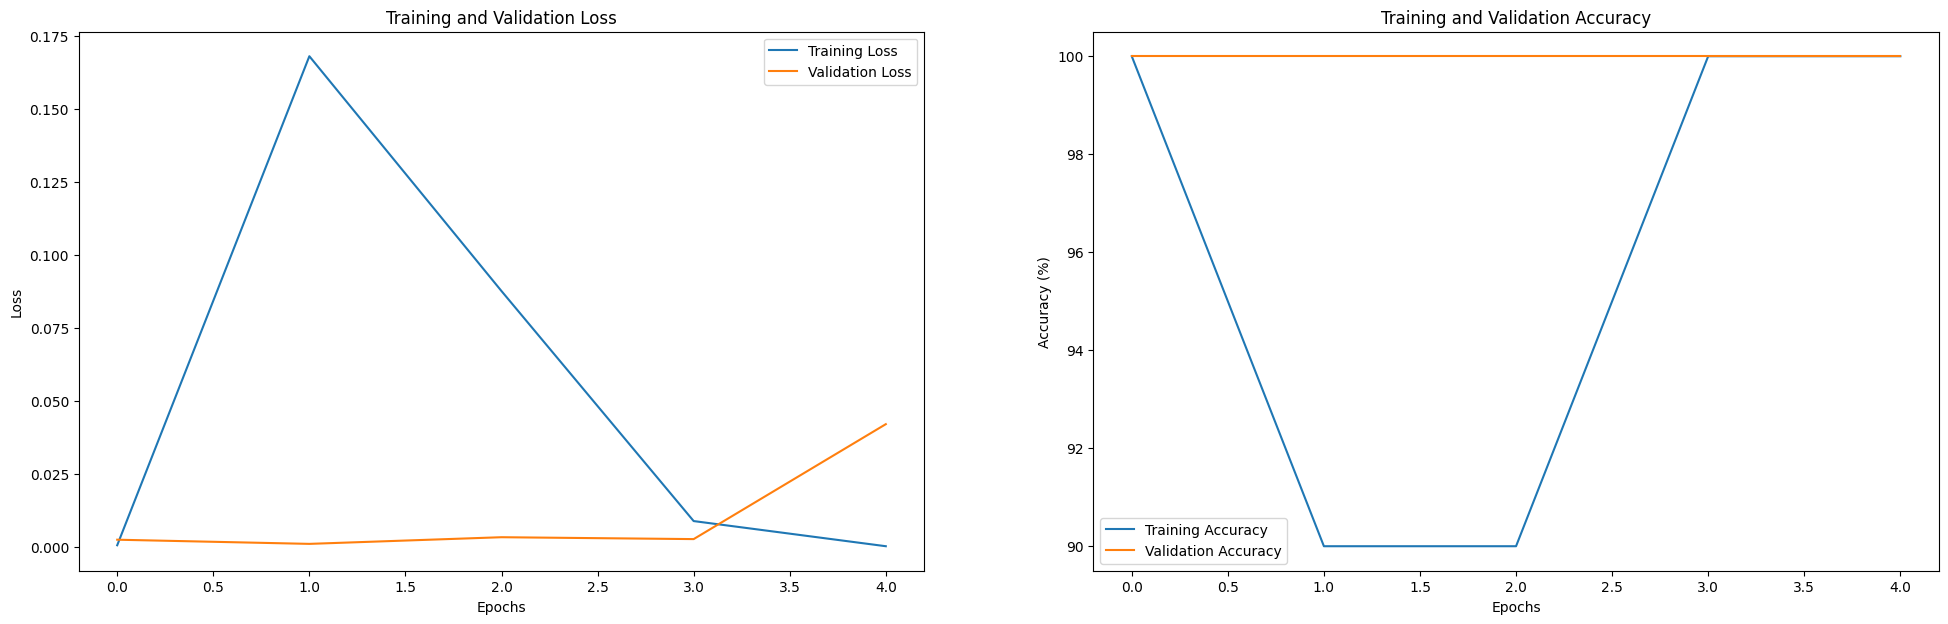

In [26]:
# After training, plot the losses and accuracies
plt.figure(figsize=(24, 7))

# Plotting Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

In [27]:
#
test_load_everything = DataLoader(test_data, batch_size=10000, shuffle=False)

In [28]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_everything:
        y_val = model.forward(X_test)
        _, predicted = torch.max(y_val, 1)
        correct += (predicted == y_test).sum()

In [31]:
# Did for correct
correct.item() / len(test_data) * 100

98.86

In [40]:
# Grab an image
# test_data[4143] # Tensor with an image in it .. at end, it shows the label


In [41]:
# Grab just the data
# test_data[4143][0]

In [42]:
# Reshape it
# test_data[4143][0].reshape(28, 28)

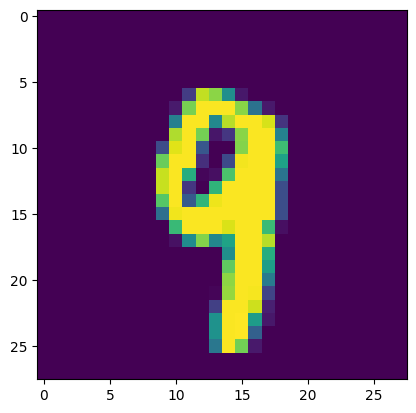

In [43]:
# Show the image
plt.imshow(test_data[4143][0].reshape(28,28))

In [44]:
# Pass the image through the model
model.eval()
with torch.no_grad():
    new_prediction =  model(test_data[4143][0].view(1,1,28,28)) # batch size of 1, 1 color channel, 28X28 image

In [45]:
# Check the new prediction ... get probabilities
new_prediction

tensor([[-2.6323e+01, -2.2043e+01, -2.5815e+01, -1.6283e+01, -1.1452e+01,
         -2.2503e+01, -3.8594e+01, -1.5411e+01, -1.7841e+01, -1.0967e-05]])

In [46]:
new_prediction.argmax()

tensor(9)